In [323]:
# Module import section
import numpy as np
import pandas as pd
from os import path
from sodapy import Socrata
import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import math
from scipy import stats

%matplotlib inline

In [324]:
# Set ipython's max row display
pd.set_option('display.max_row', 10000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

In [325]:
# API pull section
nyc_domain = "data.cityofnewyork.us"
nyc_dataset_identifier = "43nn-pn8j"
nyc_client = Socrata(nyc_domain, None)
# In final version replace with limit = 396239
nyc_results = nyc_client.get(nyc_dataset_identifier, limit = 20000)
restdata = pd.DataFrame.from_dict(nyc_results)
print(restdata.shape)

(20000, 26)


In [326]:
# Data cleaning and enhancement cell
restdata['violation_description'] = restdata['violation_description'].fillna("")
restdata['action'] = restdata['action'].fillna("")
restdata['violation_code'] = restdata['violation_code'].fillna("")
# create a list of conditions
conditions = [
    (restdata['grade'] == 'A'),
    (restdata['grade'] == 'B'),
    (restdata['grade'] == 'C'),
    ((restdata['grade'] != 'A') & (restdata['grade'] != 'B') & (restdata['grade'] != 'C'))
    ]
# create a list of the values to assign for each condition
values = [3, 2, 1, 0]
# create a new column and use np.select to assign values to it using our lists as arguments
restdata['gradeval'] = np.select(conditions, values)
# display updated DataFrame
restdata.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,gradeval
0,40827432,STARBUCKS,Manhattan,787,7 AVENUE,10019,2122456479,Café/Coffee/Tea,2018-05-25T00:00:00.000,Violations were cited in the following area(s).,10J,"""""Wash hands” sign not posted at hand wash fac...",N,12,A,2018-05-25T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Initial Inspection,40.761948488597,-73.982622296463,105,04,013100,1023157,1010040020,MN17,3
1,50049617,BAKERY MOCANA,Manhattan,1540,SAINT NICHOLAS AVENUE,10040,2127401190,"Cakes, Cupcakes, Desserts",2019-12-11T00:00:00.000,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Y,8,A,2019-12-11T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Initial Inspection,40.853147917059,-73.930914032652,112,10,026900,1063806,1021580001,MN35,3
2,41690824,UNION GROUNDS,Brooklyn,270,SMITH STREET,11231,3477631935,American,2018-07-10T00:00:00.000,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",Y,25,B,2018-07-10T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Re-inspection,40.682614864632,-73.993257686691,306,39,007500,3006840,3004210038,BK33,2
3,50045884,TAQUERIA DIANA,Manhattan,524,9 AVENUE,10018,6466844541,Mexican,2018-05-30T00:00:00.000,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,7,A,2018-05-30T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Re-inspection,40.756608343883,-73.993939589546,104,03,011500,1013674,1007630001,MN15,3
4,50076583,SZECHUAN GARDEN,Manhattan,239,WEST 105 STREET,10025,2128658808,Chinese,2019-06-12T00:00:00.000,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Y,43,C,2019-06-12T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Re-inspection,40.800270167358,-73.967409713917,107,07,019100,1056609,1018770016,MN12,1


In [327]:
restdata[restdata['score'].notna()]['score'].astype(int)

0        12
1         8
2        25
3         7
4        43
         ..
19995    60
19996    20
19997     8
19998     7
19999    12
Name: score, Length: 19051, dtype: int64

In [171]:
restdata[restdata['grade']=='A']['score'].value_counts()

12    1862
13    1473
10     956
11     918
9      876
7      636
8      329
5      278
4      194
2      183
6      119
3       95
0       28
17       1
Name: score, dtype: int64

Any time a field of what should be ints displays as floats, there are NaN values in the column.

In [7]:
restdata.cuisine_description.unique()

array(['American', 'Caribbean (Inc. Cuban, Puerto Rican)',
       'Café/Coffee/Tea', 'Pizza', 'Indian', 'Japanese', 'Chinese',
       'Eastern European', 'Italian', 'Thai', 'Irish', 'Mexican',
       'Donuts', 'Korean', 'Spanish', 'Peruvian', 'Continental',
       'Latin American (Central and South America)', 'Tex-Mex', 'French',
       'Juice, Smoothies, Fruit Salads',
       'Ice Cream, Gelato, Yogurt, Ices', 'Asian', 'Russian',
       'Cakes, Cupcakes, Desserts', 'Sandwiches', 'Hawaiian', 'Other',
       'Jewish/Kosher', 'Afghan', 'Bagels/Pretzels', 'Steak', 'Chicken',
       'African', 'Chinese/Cuban', 'Turkish', 'Vegetarian', 'Hamburgers',
       'Vietnamese/Cambodian/Malaysia', 'Barbecue',
       'Sandwiches/Salads/Mixed Buffet', 'Mediterranean', 'Bangladeshi',
       'Creole', 'German', 'Californian', 'Not Listed/Not Applicable',
       'English', 'Pancakes/Waffles', 'Middle Eastern', 'Soul Food'],
      dtype=object)

In [277]:
restdata.action.unique()

array(['Violations were cited in the following area(s).',
       'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.',
       'No violations were recorded at the time of this inspection.',
       'Establishment re-opened by DOHMH', '',
       'Establishment re-closed by DOHMH'], dtype=object)

In [9]:
restdata.violation_code.unique()

array(['06B', '04L', '04A', '08A', '08C', '04H', '06C', '06D', '04K',
       '02G', '02H', '10D', '06A', '10F', '04M', '10B', '16C', '22F',
       '02B', '06F', '10A', '04C', '15L', '04N', '18G', '08B', '05D',
       '10H', '', '10E', '09B', '06E', '16B', '20F', '03D', '09C', '03B',
       '22G', '10I', '04F', '15F6', '20D', '10J', '16D', '04J', '07A',
       '20A'], dtype=object)

In [10]:
restdata.violation_description.unique()

array(['Tobacco use, eating, or drinking from open container in food preparation, food storage or dishwashing area observed.',
       "Evidence of mice or live mice present in facility's food and/or non-food areas.",
       'Food Protection Certificate not held by supervisor of food operations.',
       'Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.',
       'Pesticide use not in accordance with label or applicable laws. Prohibited chemical used/stored. Open bait station used.',
       'Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated, or not discarded in accordance with HACCP plan.',
       'Food not protected from potential source of contamination during storage, preparation, transportation, display or service.',
       'Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.',
       "

In [11]:
restdata.critical_flag.unique()

array(['Y', 'N', nan], dtype=object)

In [190]:
restdata.score.unique()

array(['12', '8', '25', '7', '43', '16', '9', '21', '22', '28', '19', nan,
       '13', '24', '18', '14', '51', '30', '5', '0', '34', '2', '65',
       '10', '45', '17', '82', '11', '27', '40', '-1', '26', '62', '3',
       '38', '29', '95', '54', '20', '99', '42', '36', '58', '33', '46',
       '23', '4', '31', '119', '15', '39', '37', '32', '47', '52', '35',
       '74', '76', '71', '44', '59', '61', '49', '68', '122', '64', '53',
       '77', '48', '107', '6', '101', '50', '69', '55', '78', '84', '88',
       '56', '41', '85', '111', '73', '93', '57', '67', '63', '80', '94',
       '72', '60', '81', '79', '103', '91', '70', '66', '96', '87', '75',
       '92', '112', '102', '135', '86', '106', '89', '83', '164', '140',
       '90', '150', '117', '124', '129', '136', '120', '98', '141', '116',
       '104'], dtype=object)

In [191]:
restdata.grade.unique()

array(['A', 'B', 'C', nan, 'Z', 'P', 'N', 'G'], dtype=object)

In [14]:
restdata.inspection_type.unique()

array(['Cycle Inspection / Initial Inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Cycle Inspection / Re-inspection',
       'Pre-permit (Operational) / Initial Inspection',
       'Pre-permit (Operational) / Compliance Inspection',
       'Calorie Posting / Initial Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Smoke-Free Air Act / Initial Inspection',
       'Pre-permit (Operational) / Reopening Inspection',
       'Administrative Miscellaneous / Initial Inspection',
       'Inter-Agency Task Force / Initial Inspection', nan,
       'Cycle Inspection / Compliance Inspection',
       'Pre-permit (Non-operational) / Initial Inspection',
       'Trans Fat / Initial Inspection',
       'Administrative Miscellaneous / Re-inspection'], dtype=object)

In [278]:
restdata.boro.unique()

array(['Manhattan', 'Brooklyn', 'Staten Island', 'Queens', 'Bronx', '0'],
      dtype=object)

In [279]:
restdata[restdata['boro'] == '0']

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,gradeval
570,41633655,WOODSIDE CAFE RESTAURANT,0,N/A,N/A,N/A,3476423445,Indian,2017-04-17T00:00:00.000,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,7,A,2017-04-17T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5980,41664706,DELICIAS PIZZA AND CHICKEN,0,14120,HOLLY AVE,NaN,7183535070,Pizza,2019-10-28T00:00:00.000,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,45,C,2019-10-28T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7499,41669951,YORK COLLEGE CAFETERIA,0,9420,GUY R BREWER BOULEVARD,11451,7182622890,American,2019-09-10T00:00:00.000,Establishment Closed by DOHMH. Violations wer...,08A,Facility not vermin proof. Harborage or condit...,N,51,NaN,NaN,2021-02-25T06:01:33.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8702,41720552,"DUNKIN', BASKIN ROBBINS, POPEYES",0,N/A,N/A,N/A,7182576490,American,2017-04-12T00:00:00.000,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Y,44,NaN,NaN,2021-02-25T06:01:33.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8725,50005059,FREEHOLD,0,45,S 3RD ST,11249,7183887591,American,2018-06-20T00:00:00.000,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,29,NaN,NaN,2021-02-25T06:01:33.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9226,50064306,DYLAN'S CANDY BAR,0,2849,paces ferry rd,30339,7187514247,Other,2018-06-07T00:00:00.000,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,10,A,2018-06-07T00:00:00.000,2021-02-25T06:01:33.000,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


### Data Fields Summary:
Columns often have NaNs, but the data is relatively clean. There is some overlap in cuisine types when considering some unique categories contain elements shared in other categories, for example Chinese, Chinese/Japanese, Chinese/Cuban, Japanese, and Asian.

There is a data dictionary some items still aren't described, such as violation code. Others are described differently than they appear in the data, such as critical flag.

There are a variety of violation descriptions. What looked to be diverse enough to be human-written seems to be procedurally written for consistency by a wide array of possible results. Although many are related to vermin, filth, and inmproper facilities as expected some are related to staff behavior, such as use of tobacco on cooking premises.

### Columns Analysis
1) Find ratios of each health score and grade.
2) Find ratios of number of restaurants per cuisine type and across borough.
3) Perform word count analysis on flattened arrays for violation and cuisine description.

### Numeric Analysis and Hypothesis
#### Hypothesis
Does it really matter which restaurant you eat in, when considering borough or cuisine type? Check to see if there is a significant variance as cause for concern. Find distributions for analysis across multiple categories. Good candidates: Chi-squared and Kruskal-Wallis H-test.

In [16]:
restdata.nunique(axis=0) 

camis                    491
dba                      482
boro                       5
building                 442
street                   300
zipcode                  140
phone                    491
cuisine_description       51
inspection_date          380
action                     6
violation_code            47
violation_description     44
critical_flag              2
score                     64
grade                      6
grade_date               220
record_date                3
inspection_type           15
latitude                 480
longitude                480
community_board           61
council_district          51
census_tract             306
bin                      471
bbl                      477
nta                      140
dtype: int64

In [189]:
restdata.groupby('score')['camis'].nunique()

score
-1       47
0        86
10     1029
101       2
102       2
103       3
104       1
106       1
107       1
11      994
111       2
112       3
116       1
117       3
119       1
12     1931
120       1
122       1
124       1
129       1
13     1503
135       1
136       1
14      235
140       1
141       1
15      270
150       1
16      309
164       2
17      435
18      425
19      466
2       241
20      498
21      424
22      426
23      391
24      380
25      391
26      332
27      375
28      231
29      235
3       113
30      220
31      171
32      162
33      154
34      153
35      147
36      107
37      133
38      119
39      107
4       220
40      132
41       81
42      104
43       75
44       72
45       99
46       59
47       80
48       54
49       71
5       308
50       70
51       46
52       47
53       46
54       50
55       39
56       42
57       32
58       41
59       29
6       132
60       24
61       29
62       18
63       18
64       2

In [226]:
restdata.groupby('gradeval')['camis'].nunique()

gradeval
0    7321
1     461
2    1191
3    6734
Name: camis, dtype: int64

In [228]:
restdata.groupby('boro')['camis'].nunique().drop(labels='0')

boro
Bronx            1150
Brooklyn         3140
Manhattan        4919
Queens           2851
Staten Island     410
Name: camis, dtype: int64

In [17]:
restdata.groupby('cuisine_description')['camis'].nunique()

cuisine_description
Afghan                                          1
African                                         1
American                                      105
Asian                                           8
Bagels/Pretzels                                 2
Bangladeshi                                     3
Barbecue                                        3
Café/Coffee/Tea                                29
Cakes, Cupcakes, Desserts                      15
Californian                                     1
Caribbean (Inc. Cuban, Puerto Rican)           23
Chicken                                         8
Chinese                                        53
Chinese/Cuban                                   2
Continental                                     4
Creole                                          1
Donuts                                          2
Eastern European                                2
English                                         1
French                        

In [18]:
restdata.groupby('cuisine_description')['camis'].nunique()/len(restdata.index)

cuisine_description
Afghan                                        0.002
African                                       0.002
American                                      0.210
Asian                                         0.016
Bagels/Pretzels                               0.004
Bangladeshi                                   0.006
Barbecue                                      0.006
Café/Coffee/Tea                               0.058
Cakes, Cupcakes, Desserts                     0.030
Californian                                   0.002
Caribbean (Inc. Cuban, Puerto Rican)          0.046
Chicken                                       0.016
Chinese                                       0.106
Chinese/Cuban                                 0.004
Continental                                   0.008
Creole                                        0.002
Donuts                                        0.004
Eastern European                              0.004
English                                     

In [259]:
(restdata.groupby('cuisine_description')['camis'].nunique()/len(restdata.index)).sort_values(ascending = False)

cuisine_description
American                                                   0.13055
Chinese                                                    0.06050
Pizza                                                      0.04065
Café/Coffee/Tea                                            0.03500
Italian                                                    0.02570
Latin American (Central and South America)                 0.02545
Mexican                                                    0.02415
Japanese                                                   0.02225
Caribbean (Inc. Cuban, Puerto Rican)                       0.01955
Cakes, Cupcakes, Desserts                                  0.01910
Spanish                                                    0.01840
Sandwiches                                                 0.01565
Chicken                                                    0.01265
Other                                                      0.01140
Asian                                     

In [328]:
len(restdata.index)

20000

In [329]:
def makewordsetdicts(dframe):
    
    vio_word_sd = dict()
    cuis_word_sd = dict()
    for a, f in zip(dframe['violation_description'], dframe['cuisine_description']):
        b = a.translate(str.maketrans('', '', string.punctuation))
        f = f.replace('Caribbean (Inc. Cuban, Puerto Rican)', 'CaribCubanPuertoRi').replace('Latin American (Central and South America)','LatinAmerican')
        f = f.replace('Jewish/Kosher', 'JewishKosher').replace('Tex-Mex','TexMex')
        f = f.replace('Eastern European', 'EasternEuropean').replace('Middle Eastern', 'MiddleEastern')
        f = f.replace('Not Listed/Not Applicable', 'NotListed').replace('Soul Food','SoulFood')
        f = f.replace('Bottled beverages, including water, sodas, juices, etc.', 'BottledBeverages')
        g = f.replace('/',' ').translate(str.maketrans('', '', string.punctuation))
        c = b.split(" ")
        h = g.split(" ")
        for d, i in zip(c, h):
            if d.lower() in vio_word_sd:
                vio_word_sd[d.lower()] += 1
            else:
                vio_word_sd[d.lower()] = 1
            if i in cuis_word_sd:
                cuis_word_sd[i] += 1
            else:
                cuis_word_sd[i] = 1
            
    #if 'Cuban' in cuis_word_sd:
    #    cuis_word_sd['CaribCubanPuertoRi'] += cuisine_word_setDict['Cuban']
    #    del cuis_word_sd['Cuban']            
    return vio_word_sd, cuis_word_sd

In [330]:
def cleancubancuis(dct):
    if 'Cuban' in dct:
        dct['CaribCubanPuertoRi'] += dct['Cuban']
        del dct['Cuban']  
    return dct

In [331]:
violation_word_setDict, cuisine_word_setDict = makewordsetdicts(restdata)

In [332]:
vio_word_sd_bky, cuis_word_sd_bky = makewordsetdicts(restdata[restdata['boro'] == 'Brooklyn'])
vio_word_sd_qns, cuis_word_sd_qns = makewordsetdicts(restdata[restdata['boro'] == 'Queens'])
vio_word_sd_mh, cuis_word_sd_mh = makewordsetdicts(restdata[restdata['boro'] == 'Manhattan'])
vio_word_sd_brx, cuis_word_sd_brx = makewordsetdicts(restdata[restdata['boro'] == 'Bronx'])
vio_word_sd_si, cuis_word_sd_si = makewordsetdicts(restdata[restdata['boro'] == 'Staten Island'])

In [333]:
cuis_word_sd_bky = cleancubancuis(cuis_word_sd_bky)
cuis_word_sd_qns = cleancubancuis(cuis_word_sd_qns)
cuis_word_sd_mh = cleancubancuis(cuis_word_sd_mh)
cuis_word_sd_brx = cleancubancuis(cuis_word_sd_brx)
cuis_word_sd_si = cleancubancuis(cuis_word_sd_si)

In [345]:
def createcuisdf(cuiswdsdct):
    #Take a cuisine word set dictionary and return a cuisine dataframe
    cuisdf = pd.DataFrame.from_dict(cuiswdsdct, orient='index', dtype=None, columns=None)
    cuisdf = cuisdf.rename(columns={0:'Count of Cuisine Type'})
    # parameter has to be set to return correctly: inplace = False
    return cuisdf.sort_values(by='Count of Cuisine Type', axis=0, ascending=False, inplace=False, kind='quicksort')

In [349]:
# Cuisine dataframe for all of NYC
cuisinedf = createcuisdf(cuisine_word_setDict)
# Cuisine dataframe for each borough.
# Brooklyn
cuisdf_bky = createcuisdf(cuis_word_sd_bky)
# Queens
cuisdf_qns = createcuisdf(cuis_word_sd_qns)
# Manhattan
cuisdf_mh = createcuisdf(cuis_word_sd_mh)
# Bronx
cuisdf_brx = createcuisdf(cuis_word_sd_brx)
# Staten Island
cuisdf_si = createcuisdf(cuis_word_sd_si)

In [350]:
def plot_bar(data, sx, sy, lr, xl, yl):
    # Makes a bar plot from data with x and y size, label rotation, x and y labels.
    plt.figure(figsize=(sx,sy))
    data.plot.bar()
    plt.xticks(rotation=lr)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()

Call subplot with params (6, 1) for 6 rows, 1 column.
run a for loop for axs. flatten
This lets me iterate through each axis and call the plot per axis.

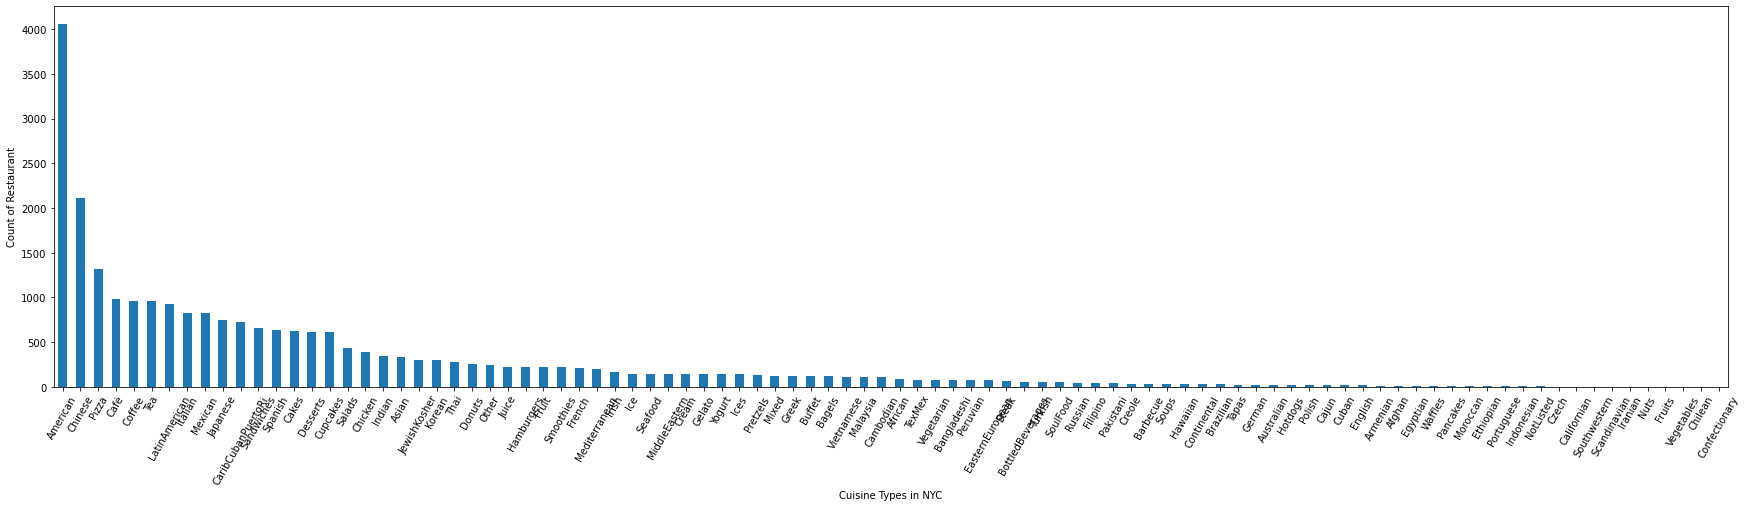

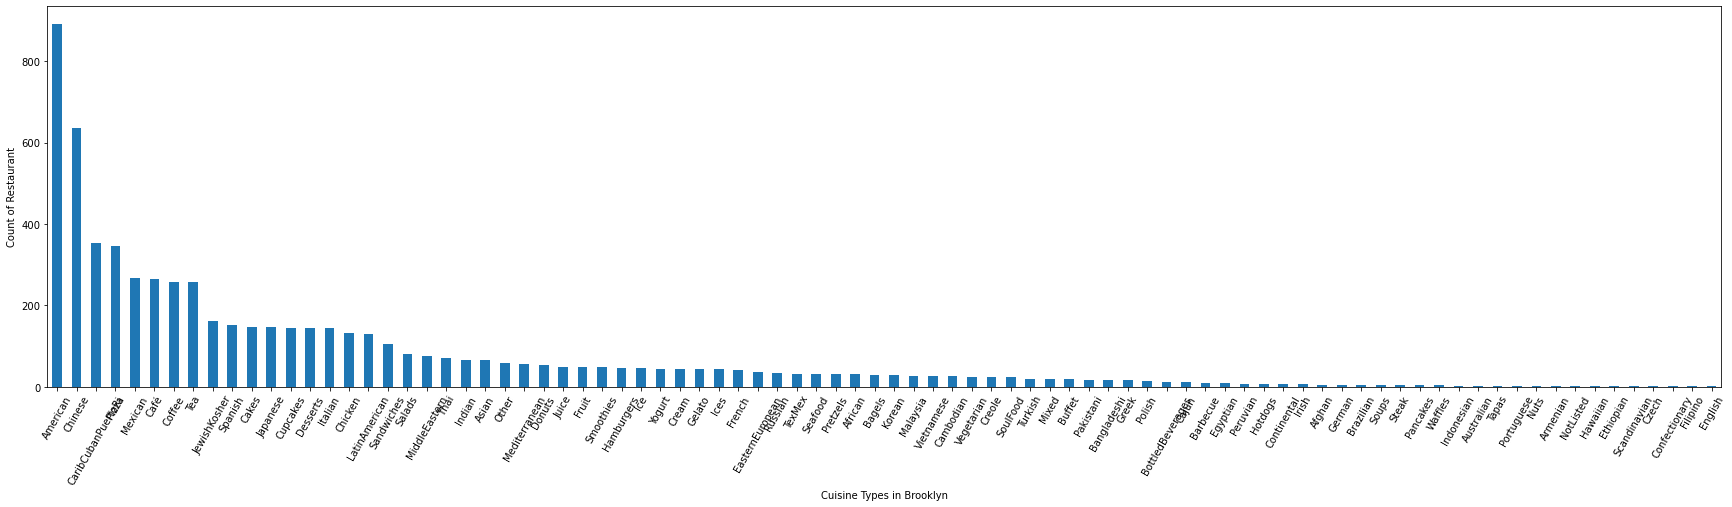

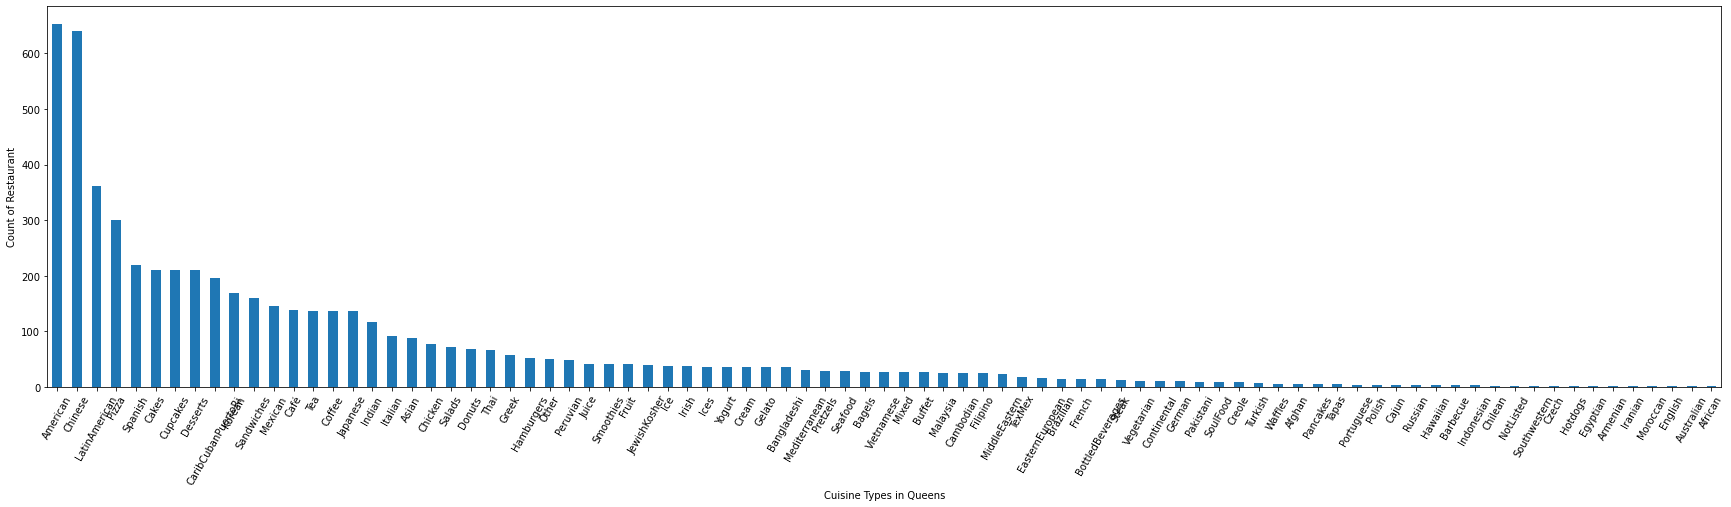

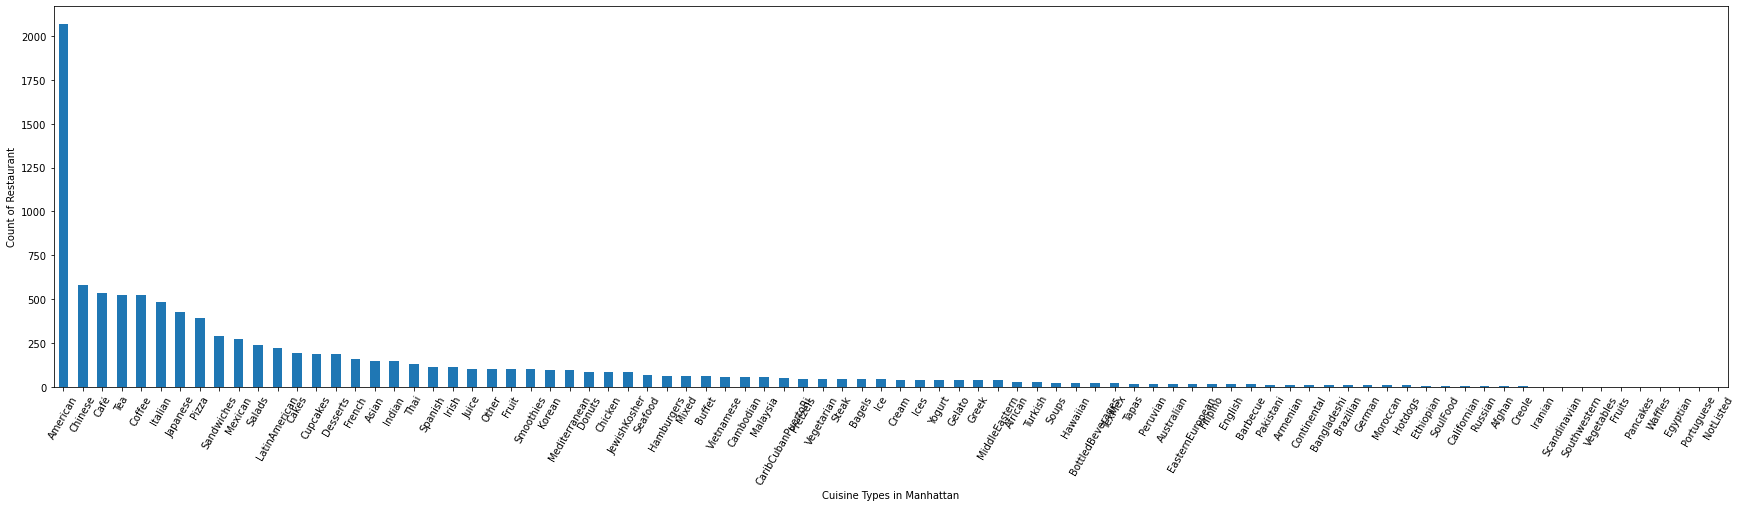

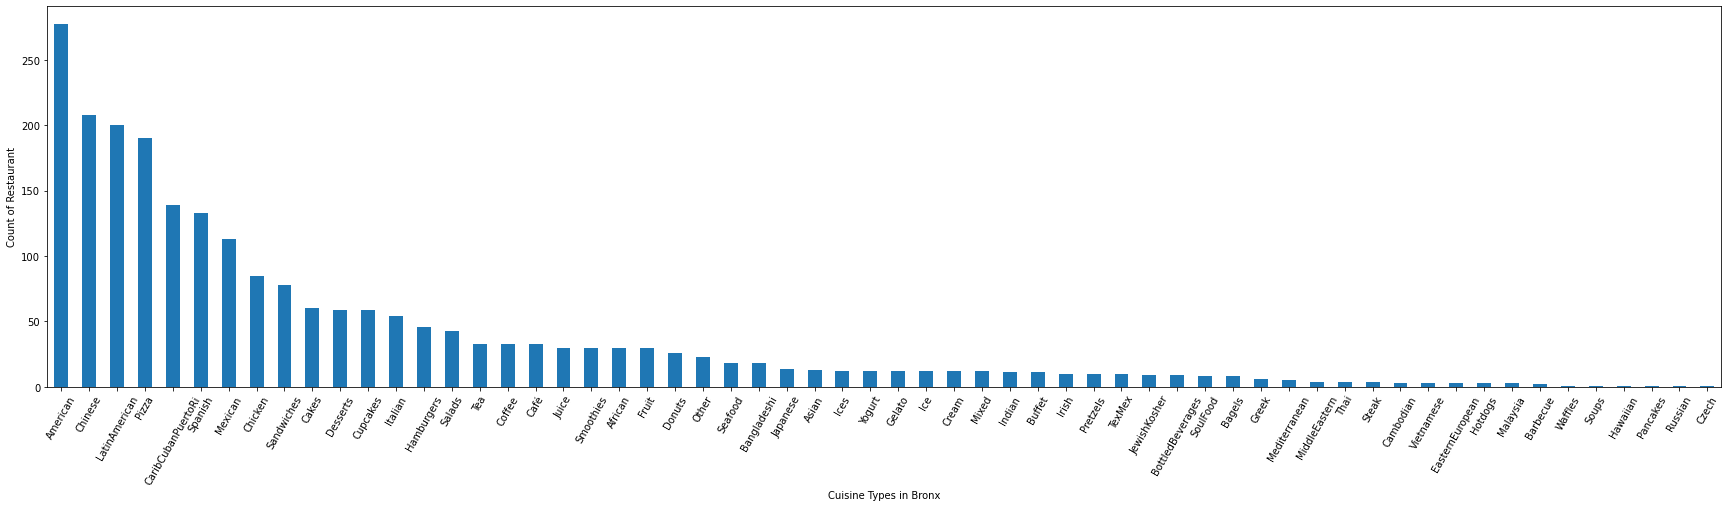

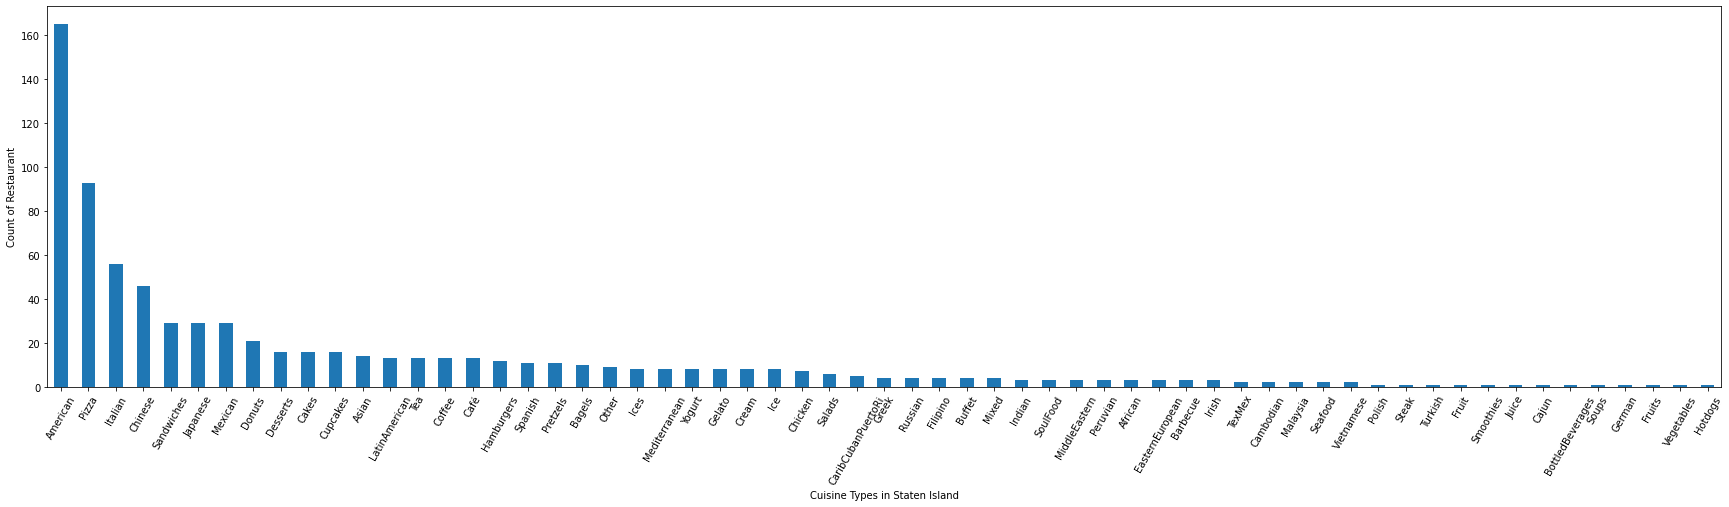

In [351]:
# Making Bar plots of restaurant types across all of NYC and each of the boroughs.
# NYC overall
plot_bar(cuisinedf['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in NYC", "Count of Restaurant")
# Brooklyn
plot_bar(cuisdf_bky['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Brooklyn", "Count of Restaurant")
# Queens
plot_bar(cuisdf_qns['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Queens", "Count of Restaurant")
# Manhattan
plot_bar(cuisdf_mh['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Manhattan", "Count of Restaurant")
# Bronx
plot_bar(cuisdf_brx['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Bronx", "Count of Restaurant")
# Staten Island
plot_bar(cuisdf_si['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in Staten Island", "Count of Restaurant")

In [ ]:
plot_bar(cuisinedf['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in NYC", "Count of Restaurant")

In [ ]:
plot_bar(cuisinedf['Count of Cuisine Type'], 30, 7, 60, "Cuisine Types in NYC", "Count of Restaurant")

In [ ]:
text = df.description[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [96]:
def dic_count_to_freq(dct):
    total = 0
    for v in dct.values():
        total += v
    for a, b in dct.items():
        dct[a] = b/total        
    return dct

In [ ]:
# dic_count_to_freq(dct)

In [147]:
def bas_word_cloud_fr_ct_dic(dct, exc):
    #Makes a basic word cloud from a dictionary of counts. Optionally exclude a list of words. ############################################################################################################
    if len(exc)> 0:
        plt.imshow(WordCloud(background_color="white",width=1000,height=1000, stopwords=STOPWORDS | exc, relative_scaling=0.5).generate_from_frequencies(dct))
    else:
        plt.imshow(WordCloud(background_color="white",width=1000,height=1000, stopwords=STOPWORDS, relative_scaling=0.5).generate_from_frequencies(dct))

In [110]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

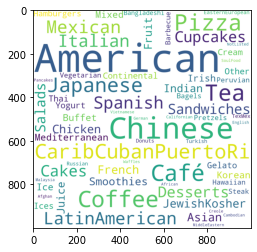

In [104]:
bas_word_cloud_fr_ct_dic(cuisine_word_setDict)

In [ ]:
excList = ['Food', 'food', 'Evidence', 'Nonfood']
for i in excList:
    if i in violation_word_setDict:
        del violation_word_setDict[i]

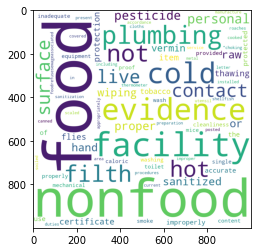

In [148]:
violation_exclude_words = {'food', 'evidence', 'nonfood'}
bas_word_cloud_fr_ct_dic(dct=violation_word_setDict, exc=violation_exclude_words)

In [179]:
type(restdata[restdata['grade']=='A']['score'].value_counts())

pandas.core.series.Series

In [181]:
restdata[restdata['grade']=='A']['score'].value_counts()

12    1862
13    1473
10     956
11     918
9      876
7      636
8      329
5      278
4      194
2      183
6      119
3       95
0       28
17       1
Name: score, dtype: int64

<AxesSubplot:>

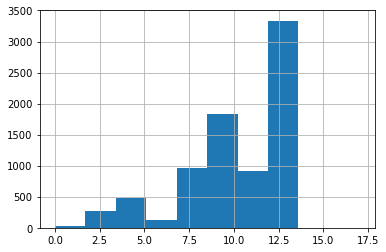

In [353]:
restdata[restdata['grade']=='A']['score'].astype(int).sort_values().hist()

In [186]:
restdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   camis                  20000 non-null  object
 1   dba                    19967 non-null  object
 2   boro                   20000 non-null  object
 3   building               19962 non-null  object
 4   street                 20000 non-null  object
 5   zipcode                19677 non-null  object
 6   phone                  19999 non-null  object
 7   cuisine_description    20000 non-null  object
 8   inspection_date        20000 non-null  object
 9   action                 19807 non-null  object
 10  violation_code         19581 non-null  object
 11  violation_description  19416 non-null  object
 12  critical_flag          19416 non-null  object
 13  score                  19051 non-null  object
 14  grade                  10099 non-null  object
 15  grade_date         

<AxesSubplot:>

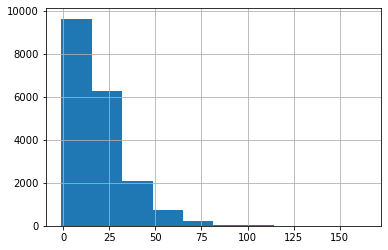

In [202]:
restdata[restdata['score'].notna()]['score'].astype(int).sort_values().hist()

In [205]:
bkscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Brooklyn'))]['score'].astype(int).sort_values()

In [206]:
qnscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Queens'))]['score'].astype(int).sort_values()

In [210]:
stats.mannwhitneyu(bkscores, qnscores, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=10179551.5, pvalue=0.028461953499360013)

In [213]:
scipy.stats.kruskal(bkscores, qnscores, nan_policy='omit')

KruskalResult(statistic=3.624829946151356, pvalue=0.05692338919576767)

In [ ]:
bkscores = restdata[((restdata['score'].notna()) & (restdata['boro'] == 'Brooklyn'))]['score'].astype(int).sort_values()

In [232]:
stats.chisquare(restdata.groupby('boro')['camis'].nunique().drop(labels='0'), f_exp=None, ddof=0, axis=0)

Power_divergenceResult(statistic=5042.013632718525, pvalue=0.0)

In [233]:
stats.chisquare(restdata.groupby('gradeval')['camis'].nunique(), f_exp=None, ddof=0, axis=0)

Power_divergenceResult(statistic=9905.7329216273, pvalue=0.0)

<AxesSubplot:xlabel='boro'>

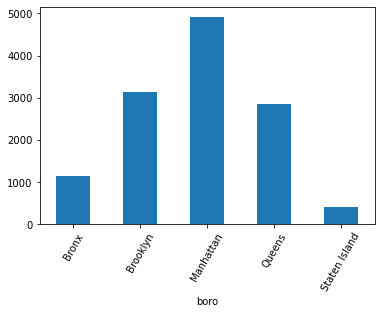

In [236]:
restdata.groupby('boro')['camis'].nunique().drop(labels='0').plot.bar(rot=60)